# Counting plankton

Assessment of the increases in phytoplankton growth during springtime warming is important for the study of global biogeochemical cycling in response to climate change. The goal is to count the number of plankton observed by the Imaging FlowCytobot (1, 2), an automated, submersible flow cytometry system, at Woods Hole Oceanographic Institution in the year 2014. Data from 2013 is labeled and data from 2014 is imputed with machine-learning predictions from a state-of-the-art ResNet fine-tuned on all data up to and including 2012. The years 2013 and 2014 have a distribution shift, primarily caused by the change in the base frequency of plankton observations. This notebook applies prediction-powered inference for label-shifted problems.

1. R. J. Olson, A. Shalapyonok, H. M. Sosik, An automated submersible flow cytometer for analyzing pico-and nanophytoplankton: FlowCytobot. Deep Sea Research Part I: Oceanographic Research Papers 50(2), 301–315 (2003).
2. E. C. Orenstein, O. Beijbom, E. E. Peacock, H. M. Sosik, WHOI-Plankton- A large scale fine grained visual recognition benchmark dataset for plankton classification. arXiv preprint arXiv:1510.00745 (2015). 

### Import necessary packages

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
import numpy as np
import pandas as pd
from scipy.stats import binom, norm
from ppi_py.datasets import load_dataset
from ppi_py import ppi_distribution_label_shift_ci, classical_mean_ci
from tqdm import tqdm
from scipy.optimize import brentq
from utils import *

### Import the plankton data set

Load the data. The data set contains hand-annotated labels indicating whether the image contains plankton (```Y```), corresponding labels predicted by a ResNet (```Yhat```), both from year 2013, and the same data from year 2014 (```Y_unlabeled``` and ```Yhat_unlabeled```, respectively). The data from 2014 is used as the unlabeled data set in the simulation.

In [2]:
dataset_folder = "./data/"
data = load_dataset(dataset_folder, "plankton")
Y = data["Y"].astype(bool)
Yhat = data["Yhat"].astype(bool)
Y_unlabeled = data["Y_unlabeled"].astype(bool)
Yhat_unlabeled = data["Yhat_unlabeled"].astype(bool)

Dataset plankton not found at location ./data/; downloading now...


### Problem setup

Specify the error level (```alpha```), range of values for the labeled data set size (```ns```), number of trials (```num_trials```), and other problem parameters.

Compute the ground-truth value of the estimand.

In [3]:
alpha = 0.05  # Total error budget
delta = 0.048  # Rectifier budget
K = 2  # Total number of classes
nu = np.array([0, 1])  # Linear contrast to estimate
n_total = Y.shape[0]  # Total number of labeled examples
N = Y_unlabeled.shape[0]  # Total number of unlabeled examples
ns = np.linspace(1000, n_total, 20).astype(
    int
)  # Test for different numbers of labeled examples
num_trials = 50

# True mean (computed on all labels)
true_theta = Y_unlabeled.sum()

### Construct intervals

Form confidence intervals for all methods and problem parameters. A dataframe with the following columns is formed:
1. ```method``` (one of ```PPI``` and ```Imputation```; due to label shift there is no classical baseline)
2. ```n``` (labeled data set size, takes values in ```ns```)
3. ```lower``` (lower endpoint of the confidence interval)
4. ```upper``` (upper endpoint of the confidence interval)
5. ```trial``` (index of trial, goes from ```0``` to ```num_trials-1```)

In [4]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for i in tqdm(range(ns.shape[0])):
    for j in range(num_trials):
        # Prediction-Powered Inference
        n = ns[i]
        rand_idx = np.random.permutation(n_total)
        _Yhat = Yhat[rand_idx[:n]]
        _Y = Y[rand_idx[:n]]

        ppi_count_ci = ppi_distribution_label_shift_ci(
            _Y, _Yhat, Yhat_unlabeled, K, nu, alpha, delta, return_counts=True
        )
        # Append results
        results += [
            pd.DataFrame(
                [
                    {
                        "method": "PPI",
                        "n": n,
                        "lower": ppi_count_ci[0],
                        "upper": ppi_count_ci[1],
                        "trial": j,
                    }
                ]
            )
        ]

# Imputed CI
imputed_ci = classical_mean_ci(Yhat_unlabeled > 0.5, alpha=alpha)

results += [
    pd.DataFrame(
        [
            {
                "method": "Imputation",
                "n": np.nan,
                "lower": imputed_ci[0] * N,
                "upper": imputed_ci[1] * N,
                "trial": 0,
            }
        ]
    )
]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


### Plot results

Plot:
1. Five randomly chosen intervals from the dataframe for PPI, and the imputed interval;
2. The average interval width for PPI, together with a scatterplot of the widths from the five random draws.

Note that due to label shift there is no classical baseline to plot.

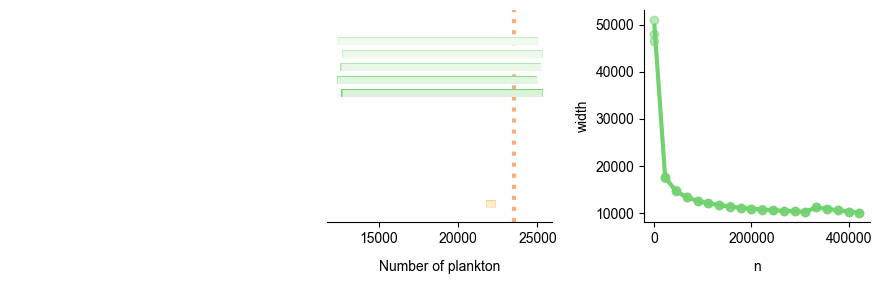

In [5]:
make_plots(
    df,
    "./plots/plankton.pdf",
    n_idx=4,
    intervals_xlabel="Number of plankton",
    plot_classical=False,
    true_theta=true_theta,
)

### Power experiment

Find the smallest value of ```n``` such that PPI has power 80% against the null $H_0: \text{number of plankton} > 10K$.

In [6]:
# Find n such that we reject H0: Number of plankton > 10K with probability 80% using a test at level alpha
num_experiments = 100
list_rand_idx = [
    np.random.permutation(n_total) for i in range(num_experiments)
]


def _to_invert_ppi(n):
    n = int(n)
    nulls_rejected = 0
    # Data setup
    for i in range(num_experiments):
        rand_idx = list_rand_idx[i]
        _Yhat = Yhat[rand_idx[:n]]
        _Y = Y[rand_idx[:n]]

        ppi_count_ci = ppi_distribution_label_shift_ci(
            _Y, _Yhat, Yhat_unlabeled, K, nu, alpha, delta, return_counts=True
        )
        if ppi_count_ci[0] > 10000:
            nulls_rejected += 1
    return nulls_rejected / num_experiments - 0.8

In [7]:
n_ppi = int(brentq(_to_invert_ppi, 1000, 100000, xtol=1))
print(
    f"The PPI test requires n={n_ppi} labeled data points to reject the null."
)

The PPI test requires n=26111 labeled data points to reject the null.
